# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from mbi import Dataset, FactoredInference, Domain, LocalInference, PublicInference
import numpy as np
from scipy import sparse
import json

/home/paul/Documents/github/PCVP_privacy/env/lib/python3.11/site-packages/mbi/__init__.py:15: UserWarning: MixtureInference disabled, please install jax and jaxlib
  warnings.warn('MixtureInference disabled, please install jax and jaxlib')


# Creating subset datasets

In [ ]:
# Create single column dataset and domain json

names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
         'marital-status', 'occupation', 'relationship', 'race',
         'gender', 'capital-gain', 'capital-loss', 'hours-per-week',
         'native-country', 'income']

adult = pd.read_csv("./data/adult.data", sep=',\s+', header=None, names=names, na_values='?', engine='python', skipinitialspace=True)
age_adult = adult[["age"]]
age_adult.to_csv("./data/age-adult.csv", index=False)
age_adult_domain = {"age": 85}
with open("./data/age-adult-domain.json", "w") as file:
    json.dump(age_adult_domain, file)

# Create two column dataset and domain json
age_edu_adult = adult[["age", "education-num"]]
age_edu_adult.to_csv("./data/two-columns-adult.csv", index=False) 
two_column_adult_domain = {"age": 85, "education-num": 16}
with open("./data/two-columns-adult-domain.json", "w") as file:
    json.dump(two_column_adult_domain, file)

# Single column implementation

In [6]:
# load adult dataset

data = Dataset.load('./data/age-adult.csv', './data/age-adult-domain.json')
domain = data.domain
total = data.df.shape[0]

print(domain)

nb_tests=20
correlations = []
for i in range(nb_tests):
    np.random.seed(i)

    # Define total budget and sensitivity
    epsilon = 0.1
    sensitivity = 1
    sigma = sensitivity/epsilon

    measurements = []
    for col in data.domain:
        # Get count for each possible value of column "age"
        x = data.project(col).datavector()
        # disturb results with laplace function
        y = x + np.random.laplace(loc=0, scale=sigma, size=x.size)
        I = sparse.eye(x.size)
        measurements.append( (I, y, sigma, (col,)) )

    # Infer data distribution and generation method from gotten count queries
    engine = FactoredInference(domain, log=True, iters=2500)

    model = engine.estimate(measurements, total=total)

    # Synthetic dataset generation
    synth_data = model.synthetic_data()

    # Calculate correlation between real and synthetic datasets
    real_data_dist = data.df["age"].value_counts(normalize=True).sort_index()
    synth_data_dist = synth_data.df["age"].value_counts(normalize=True).sort_index()

    correlation = real_data_dist.corr(synth_data_dist)
    print(f"Got a correlation between the two datasets of: {correlation}")
    correlations.append(correlation)

Domain(age: 85)
Total clique size: 85
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		4058.47		114301.43		0.00
50.00		0.06		69.45		47.92		0.00
100.00		0.15		29.15		13.31		0.00
150.00		0.24		23.05		10.34		0.00
200.00		0.32		20.73		9.57		0.00
250.00		0.40		19.59		9.28		0.00
300.00		0.48		19.05		9.15		0.00
350.00		0.56		18.72		9.09		0.00
400.00		0.65		18.51		9.05		0.00
450.00		0.72		18.38		9.03		0.00
500.00		0.80		18.29		9.01		0.00
550.00		0.89		18.24		9.00		0.00
600.00		0.98		18.21		9.00		0.00
650.00		1.08		18.20		8.99		0.00
700.00		1.19		18.19		8.99		0.00
750.00		1.27		18.18		8.99		0.00
800.00		1.35		18.18		8.98		0.00
850.00		1.44		18.17		8.98		0.00
900.00		1.51		18.17		8.98		0.00
950.00		1.59		18.17		8.98		0.00
1000.00		1.67		18.17		8.98		0.00
1050.00		1.75		18.16		8.98		0.00
1100.00		1.83		18.16		8.98		0.00
1150.00		1.90		18.16		8.98		0.00
1200.00		1.98		18.16		8.98		0.00
1250.00		2.06		18.16		8.98		0.00
1300.00		2.14		18.16		8.98		0.00
1350.00		2.22		18.16		8.98		0.00
1400

In [10]:
print(f"Got an average correlation over {nb_tests} tests of: {sum(correlations)/len(correlations)}")


Got an average correlation over 20 tests of: 0.9995898691198469


Text(0.5, 1.0, 'Age distribution for both datasets')

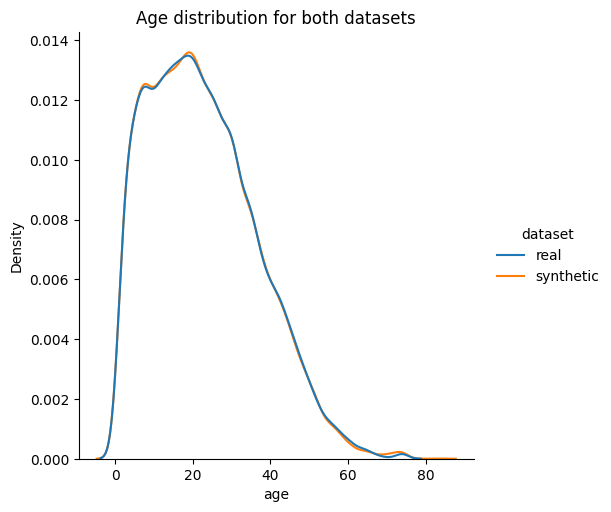

In [5]:
# Generate age distribution graph for both datasets

df_1 = data.df
df_1["dataset"] = ["real" for _ in range(df_1.shape[0])]
df_2 = synth_data.df
df_2["dataset"] = ["synthetic" for _ in range(df_1.shape[0])]
df = pd.concat([df_1, df_2], axis=0)
sns.displot(data=df, x="age", hue="dataset", kind="kde")
plt.title("Age distribution for both datasets")

# Two Column implementation

In [6]:
# load adult dataset

data = Dataset.load('./data/two-columns-adult.csv', './data/two-columns-adult-domain.json')
domain = data.domain
total = data.df.shape[0]

print(domain)

np.random.seed(8169977)

# Define queries to make on multiple columns, in this two columns case, only one is possible
multi_column_requests = [('age', 'education-num')]

# Define total epsilon budget and split it between the 3 possible types of queries
total_epsilon = 0.1
epsilon_split = total_epsilon / (len(data.domain) + len(multi_column_requests))
sensitivity = 1
sigma = sensitivity/epsilon_split

measurements = []
for col in data.domain:
    # Colecting real counts
    x = data.project(col).datavector()
    # Disturbing results
    y = x + np.random.laplace(loc=0, scale=sigma, size=x.size)
    I = sparse.eye(x.size)
    measurements.append( (I, y, sigma, (col,)) )

for cl in multi_column_requests:
    # Calculating counts for each value combination between the two columns
    x = data.project(cl).datavector()
    # Disturbing the results
    y = x + np.random.laplace(loc=0, scale=sigma, size=x.size)
    I = sparse.eye(x.size)
    measurements.append( (I, y, sigma, cl) )

# Infer data distribution and generation method from gotten count queries
engine = FactoredInference(domain, log=True, iters=2500)

model = engine.estimate(measurements, total=total)

# Synthetic data generation
synth_data = model.synthetic_data()
synth_data.df.head()

Domain(age: 85, education-num: 16)
Total clique size: 1360
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		5767.46		189232.45		0.00


50.00		0.15		1737.30		2072.96		0.00
100.00		0.30		1369.23		1249.30		0.00
150.00		0.44		1267.07		1094.63		0.00
200.00		0.60		1217.59		1024.38		0.00
250.00		0.77		1190.14		985.13		0.00
300.00		0.92		1174.41		961.36		0.00
350.00		1.04		1165.27		946.14		0.00
400.00		1.17		1159.65		935.94		0.00
450.00		1.33		1156.06		928.87		0.00
500.00		1.49		1153.63		923.86		0.00
550.00		1.65		1152.05		920.23		0.00
600.00		1.77		1151.04		917.55		0.00
650.00		1.94		1150.35		915.54		0.00
700.00		2.10		1149.80		914.00		0.00
750.00		2.24		1149.36		912.81		0.00
800.00		2.37		1149.02		911.87		0.00
850.00		2.49		1148.74		911.12		0.00
900.00		2.63		1148.51		910.52		0.00
950.00		2.81		1148.32		910.03		0.00
1000.00		2.99		1148.19		909.62		0.00
1050.00		3.18		1148.07		909.28		0.00
1100.00		3.37		1147.98		909.00		0.00
1150.00		3.53		1147.90		908.76		0.00
1200.00		3.66		1147.84		908.56		0.00
1250.00		3.80		1147.79		908.39		0.00
1300.00		3.94		1147.75		908.23		0.00
1350.00		4.12		1147.71		908.10		0.00
1400.00		4.30		11

,age,education-num
0,7,12
1,22,8
2,20,9
3,27,8
4,30,13


Text(0.5, 1.0, 'Age distribution for both datasets')

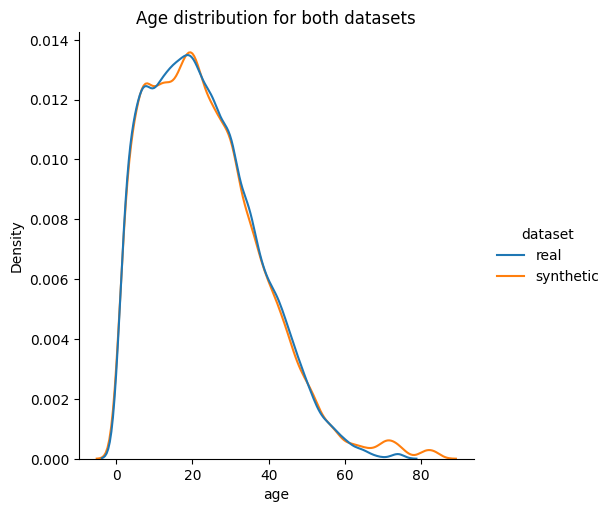

In [7]:
# Plotting age distribution

df_1 = data.df
df_1["dataset"] = ["real" for _ in range(df_1.shape[0])]
df_2 = synth_data.df
df_2["dataset"] = ["synthetic" for _ in range(df_1.shape[0])]
df = pd.concat([df_1, df_2], axis=0)
sns.displot(data=df, x="age", hue="dataset", kind="kde")
plt.title("Age distribution for both datasets")

Text(0.5, 1.0, 'Education distribution for both datasets (logarithmic scale)')

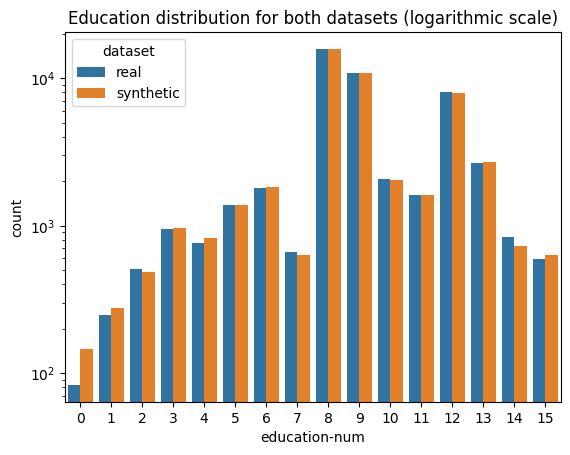

In [8]:
# Plotting distribution of education-num

df_1 = data.df
df_1["dataset"] = ["real" for _ in range(df_1.shape[0])]
df_2 = synth_data.df
df_2["dataset"] = ["synthetic" for _ in range(df_1.shape[0])]
df = pd.concat([df_1, df_2], axis=0)
sns.countplot(data=df, x="education-num", hue="dataset")
plt.yscale("log")
plt.title("Education distribution for both datasets (logarithmic scale)")

In [9]:
# Calculating correlation
real_data_dist = pd.Series(data.project(["age", "education-num"]).datavector())
synth_data_dist = pd.Series(synth_data.project(["age", "education-num"]).datavector())

correlation = real_data_dist.corr(synth_data_dist)
print(correlation)

0.9645065187751792


Text(0.5, 1.0, 'Age distribution per education category')

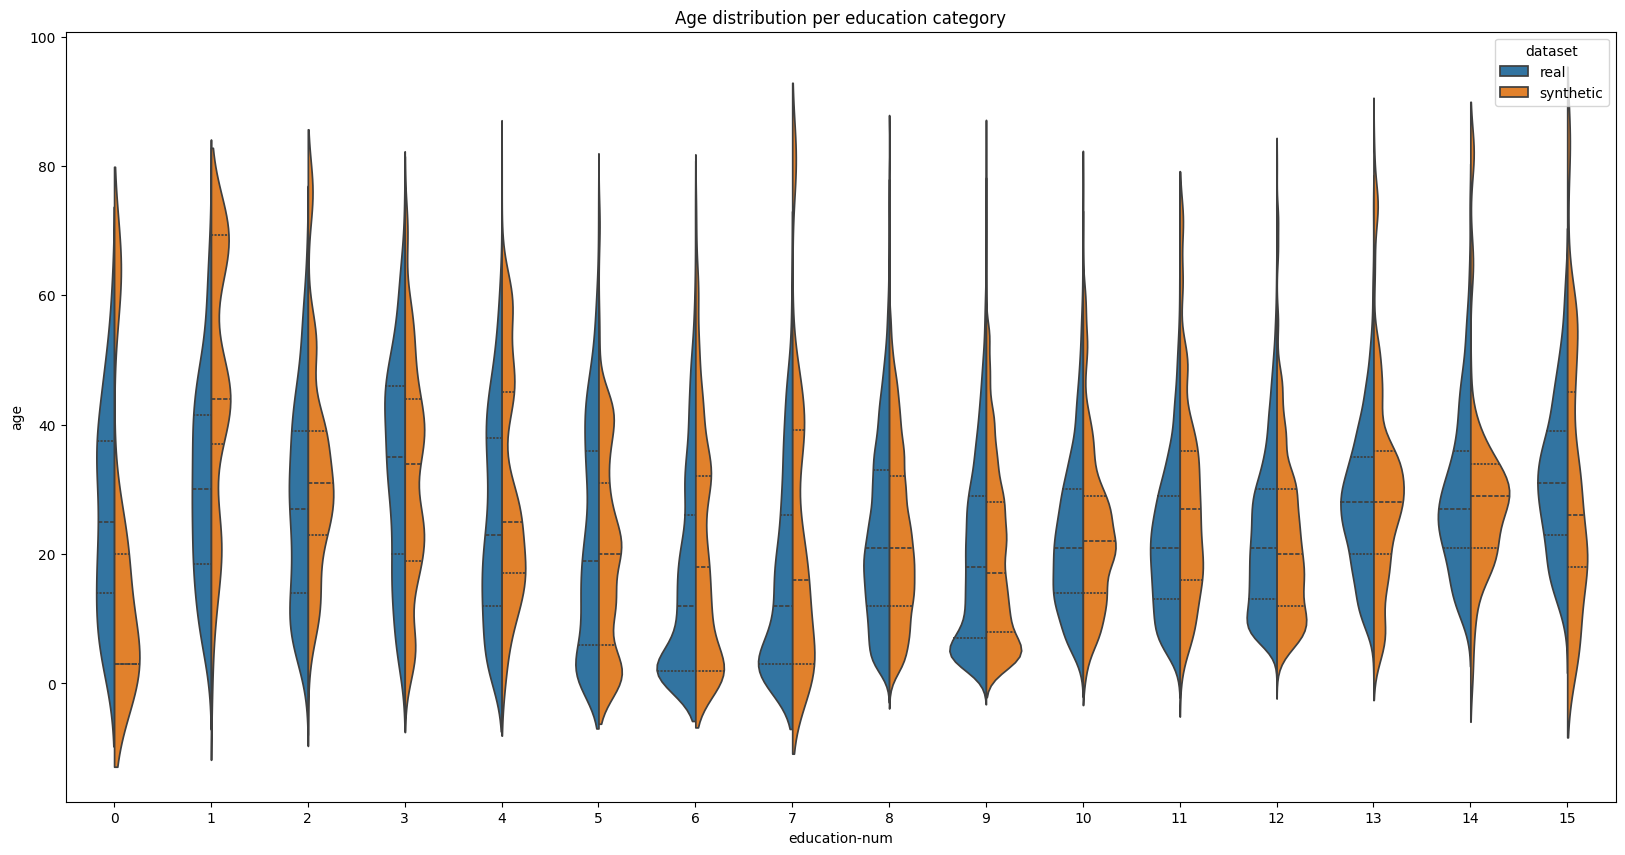

In [10]:
# Plotting distribution of age based on education num
df_1 = data.df
df_1["dataset"] = ["real" for _ in range(df_1.shape[0])]
df_2 = synth_data.df
df_2["dataset"] = ["synthetic" for _ in range(df_1.shape[0])]
df = pd.concat([df_1, df_2], axis=0)
plt.figure(figsize=(20,10))
sns.violinplot(data=df, x="education-num", y="age", hue="dataset", inner="quart", split=True)
plt.title("Age distribution per education category")